<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN_arrhythmia_ECG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Arrhythmia on ECG Classification using CNN

Источник данных:
https://physionet.org/content/mitdb/1.0.0/mitdbdir/src/#files-panel


Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn/notebook

In [1]:
!pip install keras

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

In [29]:
from keras.utils import to_categorical

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
train_df = pd.read_csv('/content/drive/MyDrive/edf_process/mitbih_train.csv', header=None, index_col=0) #, nrows=1000)
test_df = pd.read_csv('/content/drive/MyDrive/edf_process/mitbih_test.csv', header=None, index_col=0) #, nrows=1000)

In [173]:
print(test_df.shape , train_df.shape)

(10000, 187) (10000, 187)


In [174]:
test_df.head()

,1,2,3,4,5,6,7,8,9,10,...,178,179,180,181,182,183,184,185,186,187
0,,,,,,,,,,,,,,,,,,,,,
1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
train_df.head()

,1,2,3,4,5,6,7,8,9,10,...,178,179,180,181,182,183,184,185,186,187
0,,,,,,,,,,,,,,,,,,,,,
0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([72471.,     0.,  2223.,     0.,     0.,  5788.,     0.,   641.,
            0.,  6431.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

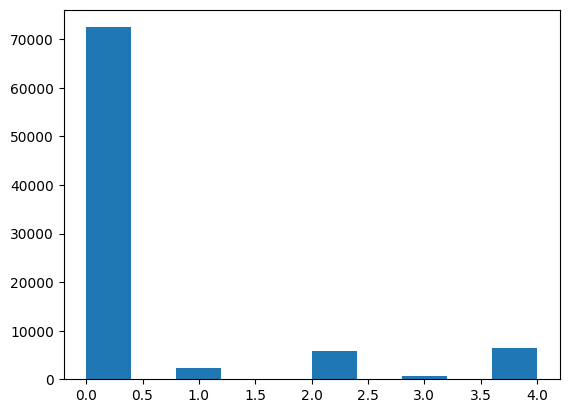

In [177]:
plt.hist(train_df.iloc[:,-1])

In [117]:
train_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,178,179,180,181,182,183,184,185,186,187
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,0.803555,0.452495,0.208555,0.172072,0.177267,0.171338,0.174328,0.174704,0.182606,0.186867,...,0.005407,0.005411,0.005423,0.005506,0.005643,0.005612,0.005560,0.005776,0.005897,0.0
std,0.168237,0.226987,0.171641,0.132060,0.128438,0.143401,0.152646,0.154708,0.158481,0.161646,...,0.038489,0.038765,0.038585,0.039145,0.040335,0.040201,0.039732,0.041260,0.042290,0.0
min,0.106383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002392,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.743625,0.313041,0.069711,0.082099,0.089498,0.074774,0.070284,0.070798,0.068818,0.064567,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.856768,0.472840,0.202104,0.145348,0.155203,0.134395,0.109932,0.124795,0.136942,0.128356,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.922921,0.628102,0.299632,0.229394,0.236927,0.241257,0.249111,0.253412,0.256373,0.284568,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,0.762626,0.752525,0.752525,0.772727,0.792929,0.828283,0.843434,0.823232,...,0.311755,0.321976,0.311755,0.315162,0.332198,0.333901,0.327087,0.339012,0.352641,0.0


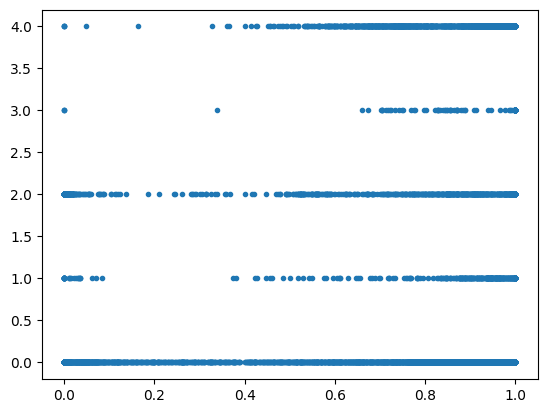

In [178]:
plt.plot(test_df.iloc[:,-1],'.')

In [179]:
x_train = train_df.iloc[: , :-1]
x_test = test_df.iloc[: , :-1]
y_train = train_df.iloc[: , -1]
y_test =  test_df.iloc[: , -1]

print(x_train.shape , x_test.shape)
print(y_train.shape , y_test.shape)

(87554, 186) (21892, 186)
(87554,) (21892,)


In [180]:

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

print(y_train.shape , y_test.shape)

(87554, 5) (21892, 5)


In [181]:
x_train = np.expand_dims(x_train , -1)
x_test = np.expand_dims(x_test , -1)

print(x_test.shape , x_train.shape)

(21892, 186, 1) (87554, 186, 1)


# Data Balancing

In [77]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


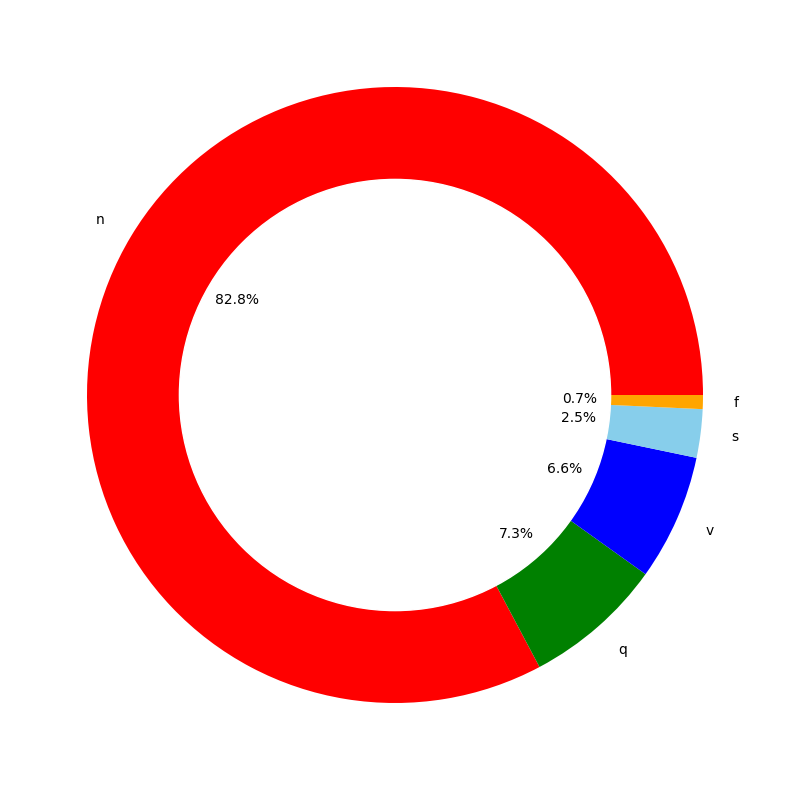

In [78]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [79]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [80]:
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


In [81]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

<ipython-input-81-3d45953f5d37>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))


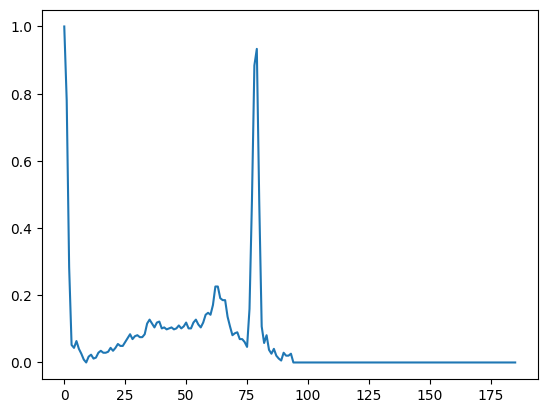

In [82]:
 plt.plot(c.iloc[0,:186])

In [83]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [84]:
# что-то надо сделать с нулями в выборке!!!!!!!
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

In [85]:
def network(X_train,y_train,X_test,y_test):


    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [86]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

# NN model

In [183]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import shutil
from IPython.display import display
import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, BatchNormalization, Input, Activation, Dropout, Convolution1D, Conv1D, MaxPool1D , MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, MaxPool2D
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , Lambda, GaussianNoise

from keras.utils import to_categorical

from keras.optimizers import Adam , Adadelta , Adagrad , SGD , RMSprop
from keras import regularizers
import tensorflow.keras.backend as K
from random import choice,shuffle
from sklearn.metrics import classification_report
import glob

In [184]:
m = Sequential()

m.add(GaussianNoise(0.1))

m.add(Conv1D(16,
                input_shape=[186, 1],
                kernel_size=80,
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(32,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(64,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(96,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Conv1D(96*2,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=2, strides=None))

m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer

m.add(Flatten())
m.add(Dense(32, activation='relu'))
m.add(Dropout(0.5))
m.add(Dense(16, activation='relu'))

m.add(Dropout(0.5))
m.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [185]:
m.build(input_shape=(None, 186, 1))
m.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gaussian_noise_15 (GaussianNoise)    │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 93, 16)              │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 93, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 93, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_59 (MaxPooling1D)      │ (None, 46, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_60 (Conv1D)                   │ (None, 46, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 46, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_60 (MaxPooling1D)      │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 23, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 23, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 11, 96)              │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 11, 96)              │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 11, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 5, 96)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 5, 192)              │          55,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 5, 192)              │             768 │
│ (BatchNormalization)                 │                             │              

 Total params: 91,477 (357.33 KB)

 Trainable params: 90,677 (354.21 KB)

 Non-trainable params: 800 (3.12 KB)

In [186]:
m.compile(optimizer=Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [188]:
batch_size = 128


m.fit(x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=3,
        verbose=1,
        #validation_split = 0.2,
)

Epoch 1/3
685/685 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.9261 - loss: 0.3524
Epoch 2/3
685/685 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - accuracy: 0.9267 - loss: 0.3339
Epoch 3/3
685/685 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9291 - loss: 0.3135


In [189]:
loss, accuracy = m.evaluate(x_test, y_test)
print('Test model loss:', loss)
print('Test model accuracy:', accuracy)

685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9907 - loss: 0.1083
Test model loss: 0.22702185809612274
Test model accuracy: 0.9546866416931152


# keras

In [160]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
import keras

from tensorflow.keras.layers import BatchNormalization

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [162]:

model,history=keras.network(x_train,y_train,x_test,y_test)

AttributeError: module 'keras' has no attribute 'network'

In [35]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

NameError: name 'history' is not defined

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()